## This notebook performs the following EDA(Exploratory Data Analysis):
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

**Note:** We use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

In [1]:
## Import dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import pydicom
from PIL import Image

In [2]:
## Read all of the full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
74426,00018254_018.png,Atelectasis,18,18254,29,F,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00018254_018.png
48176,00012213_001.png,No Finding,1,12213,55,F,PA,2738,2725,0.143,0.143,NaN,/data/images_006/images/00012213_001.png
56254,00014018_011.png,Pneumothorax,11,14018,46,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014018_011.png


In [3]:
## Split up "Finding Labels" column so that there is one column in the NIH dataframe per disease, with a binary flag.
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
35083,00009256_000.png,No Finding,0,9256,54,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
92138,00023003_004.png,No Finding,4,23003,30,M,PA,2574,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
42610,00010973_000.png,Effusion,0,10973,76,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Found an outlier with age of over 400 in the dataset, exclusing it from the following analysis
sliced_xray_df = all_xray_df[all_xray_df['Patient Age'].isin(range(120))]
sliced_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
16301,00004344_032.png,Atelectasis|Cardiomegaly,32,4344,48,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3039,00000805_003.png,No Finding,3,805,46,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20060,00005365_014.png,No Finding,14,5365,13,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
## Frequencies of all findings in dataset
sliced_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103086
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020532
Effusion              0.118766
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177408
Mass                  0.051543
No Finding            0.538289
Nodule                0.056466
Pleural_Thickening    0.030182
Pneumonia             0.012754
Pneumothorax          0.047280
dtype: float64

**Note:** Pneumonia only occurs at about 1% frequency in this dataset. Later when we split our dataset into train and validation sets, we might want to increase Pneumonia's frequency of occurance. The reason is that while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia.

[Text(0, 0.5, 'Number of Images with Label')]

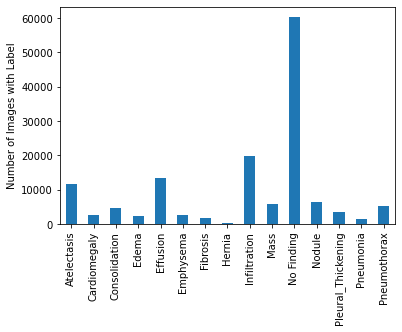

In [6]:
## Bar graph of the number of each findings
ax = sliced_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

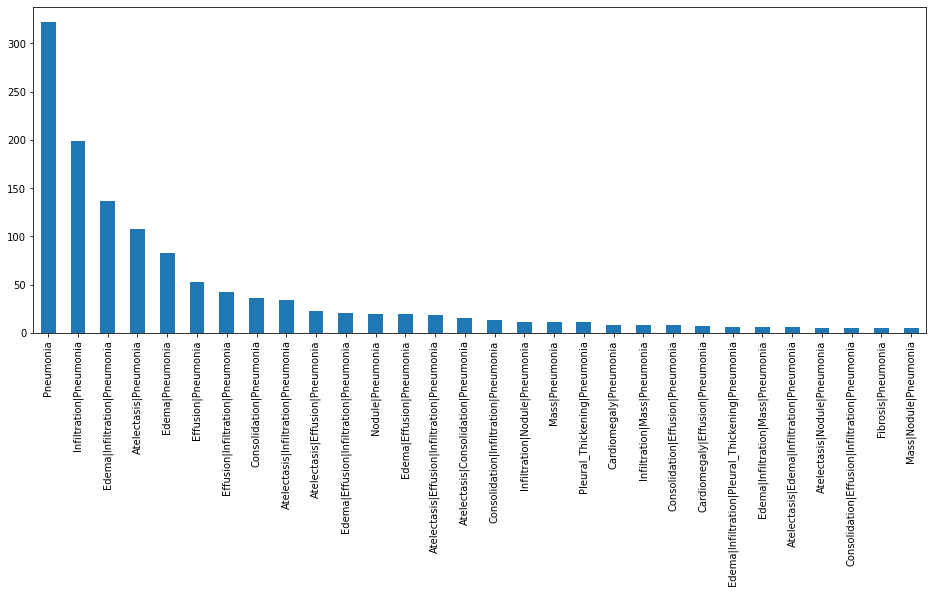

In [7]:
## look at the 30 most common co-occurrences of Pneumonia:
plt.figure(figsize=(16, 6))
sliced_xray_df[sliced_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Looks like mostly pneumonia occurs by itself, but it is also common to have co-occurance of pneumonia with other conditions such as infiltration, edema and atelectasis.Now let's plot the demographics of patients with pneumonia to see whether there are any useful information that we can get. It is very important to know what demographic data our algorithm is trained on so that we know its limitations. 

Text(0.5, 1.0, 'View Position')

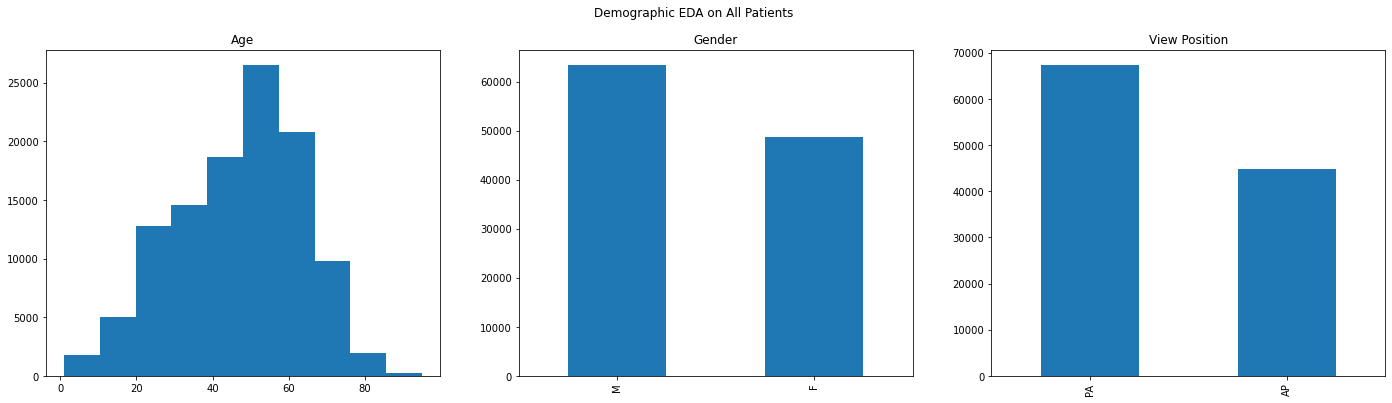

In [8]:
## Plot the demographic EDA on ALL patients
fig = plt.figure(figsize=(24, 6))
fig.suptitle('Demographic EDA on All Patients')
fig.add_subplot(1, 3, 1)
plt.hist(sliced_xray_df['Patient Age'])
plt.title('Age')
fig.add_subplot(1, 3, 2)
sliced_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Gender')
fig.add_subplot(1, 3, 3)
sliced_xray_df['View Position'].value_counts().plot(kind='bar')
plt.title('View Position')

Text(0.5, 1.0, 'View Position')

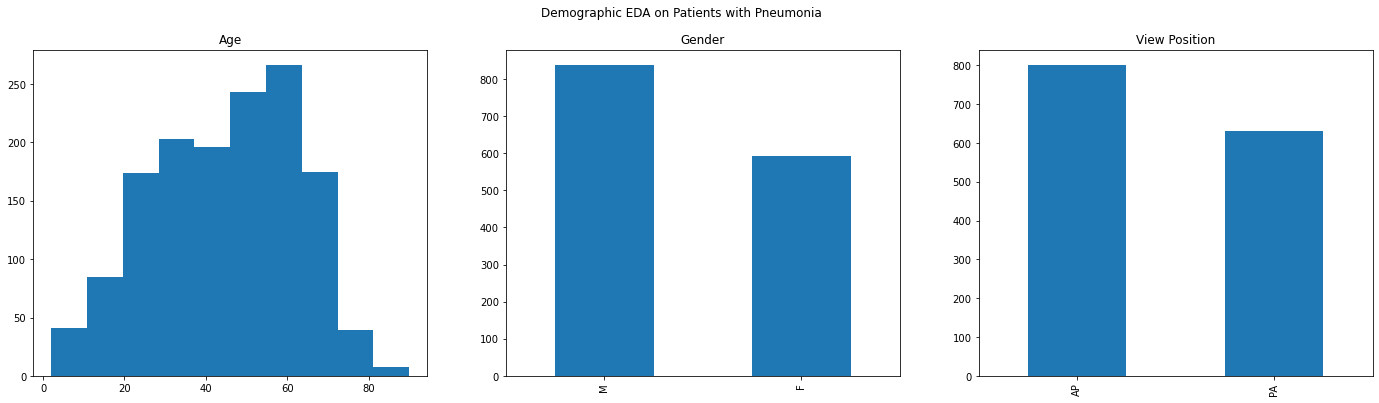

In [9]:
## Plot the demographic EDA on patients with Pneumonia
fig = plt.figure(figsize=(24, 6))
fig.suptitle('Demographic EDA on Patients with Pneumonia')
fig.add_subplot(1, 3, 1)
plt.hist(sliced_xray_df[sliced_xray_df.Pneumonia==1]['Patient Age'])
plt.title('Age')
fig.add_subplot(1, 3, 2)
sliced_xray_df[sliced_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Gender')
fig.add_subplot(1, 3, 3)
sliced_xray_df[sliced_xray_df.Pneumonia==1]['View Position'].value_counts().plot(kind='bar')
plt.title('View Position')

From the plots shown above we can see that the age distribution for all patients is nearly normal across ages between 0 and 90. The gender distribution of our data on all patients has slightly more male than female. The age and gender distributions for all patients and those for patients with pneumonia matches approximately. However, more patients were taken the chest X-ray in PA postion than those taken in AP. This is opposite in patients with pneumonia. But the relative difference in view position is small and the clinical difference between the two positions are the distance between patient and the x-ray tube, which doesn't alter patient data but factors in as more of an enhancement. So here we conclude that the demographics of all patients and that of patients with pneumonia matches each other approximately.  

Now let's take a look at some of the images for pixel level assessments. 

In [10]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_image_paths = {os.path.basename(x): x for x in
                      glob(os.path.join('/data', 'images*', '*', '*.png'))}
print('Scans found:', len(sample_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(sample_image_paths.get)
sample_df.sample(n=10)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4662,00023315_000.png,Atelectasis,0,23315,027Y,M,PA,3056,2544,0.139,0.139,/data/images_010/images/00023315_000.png
2847,00014125_034.png,No Finding,34,14125,028Y,M,AP,2500,2048,0.168,0.168,/data/images_007/images/00014125_034.png
3789,00018614_005.png,No Finding,5,18614,003Y,M,PA,2278,1741,0.143,0.143,/data/images_009/images/00018614_005.png
2046,00010607_004.png,No Finding,4,10607,059Y,M,AP,2500,2048,0.168,0.168,/data/images_005/images/00010607_004.png
1815,00009574_024.png,Atelectasis|Consolidation|Effusion|Infiltration,24,9574,056Y,M,PA,2992,2913,0.143,0.143,/data/images_005/images/00009574_024.png
2002,00010449_004.png,No Finding,4,10449,044Y,F,AP,2048,2500,0.168,0.168,/data/images_005/images/00010449_004.png
3719,00018251_014.png,Consolidation,14,18251,006Y,M,AP,2048,2500,0.168,0.168,/data/images_008/images/00018251_014.png
4892,00025787_012.png,Effusion|Infiltration|Nodule,12,25787,027Y,M,AP,3056,2544,0.139,0.139,/data/images_011/images/00025787_012.png
1160,00006144_001.png,No Finding,1,6144,049Y,M,PA,2992,2991,0.143,0.143,/data/images_003/images/00006144_001.png
590,00003053_001.png,No Finding,1,3053,083Y,M,AP,2500,2048,0.168,0.168,/data/images_002/images/00003053_001.png


Text(0.5, 1.0, 'Pixel Intensities')

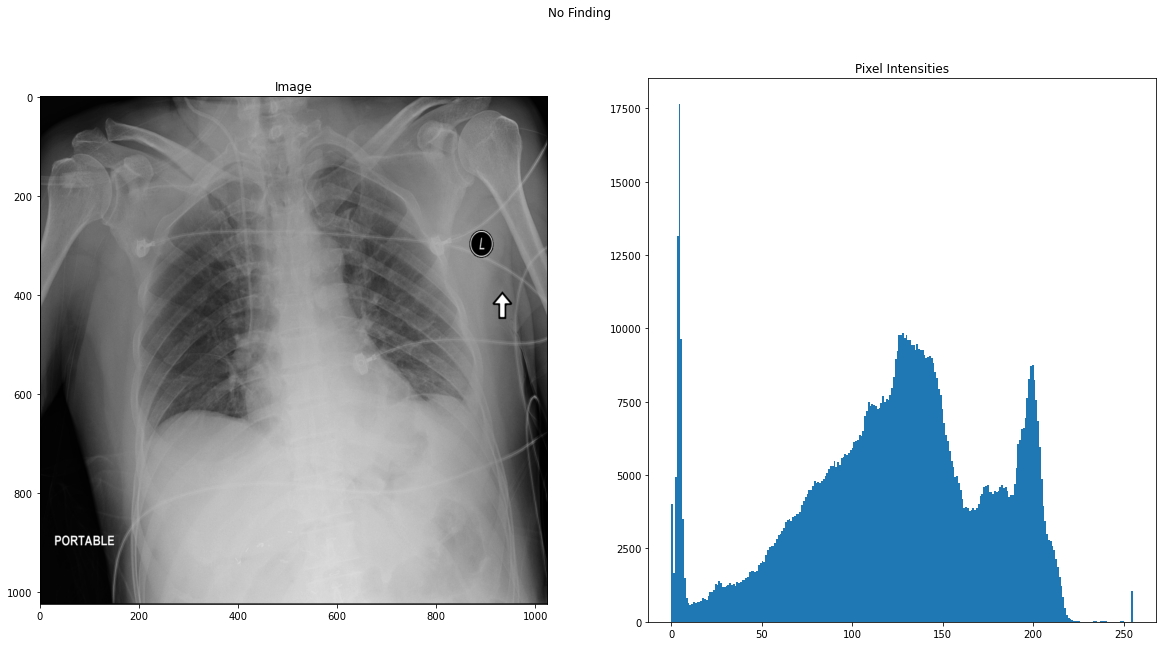

In [11]:
## An example of No Finding
image_path = '/data/images_009/images/00020380_002.png'
image = Image.open(image_path, 'r')
pixels = np.array(image)

fig = plt.figure(figsize=(20, 10))
fig.suptitle('No Finding')
fig.add_subplot(1, 2, 1)
plt.imshow(pixels, cmap='gray')
plt.title('Image')
fig.add_subplot(1, 2, 2)
plt.hist(pixels.ravel(), bins = 256)
plt.title('Pixel Intensities')

Text(0.5, 1.0, 'Pixel Intensities')

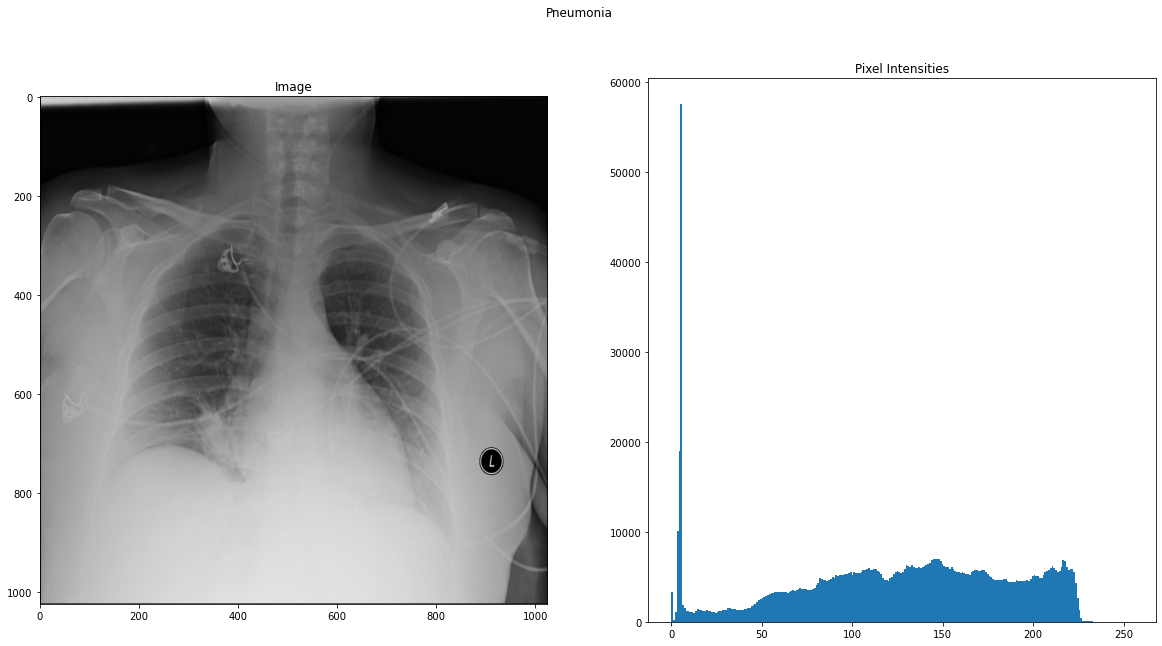

In [12]:
## An example of Pneumonia
image_path = '/data/images_011/images/00026179_003.png'
image = Image.open(image_path, 'r')
pixels = np.array(image)

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Pneumonia')
fig.add_subplot(1, 2, 1)
plt.imshow(pixels, cmap='gray')
plt.title('Image')
fig.add_subplot(1, 2, 2)
plt.hist(pixels.ravel(), bins = 256)
plt.title('Pixel Intensities')

Just by looking at the intensity profile of 'No Finding' and 'Pneumonia', we see that there is very little that we can tell, since they both have similar modes around 140 and the overall profile looks similar. However, it does seem like 'Pneumonia' image has more pixels with intensity a little above 0 than that of 'No Finding'. 

Text(0.5, 1.0, 'Pixel Intensities')

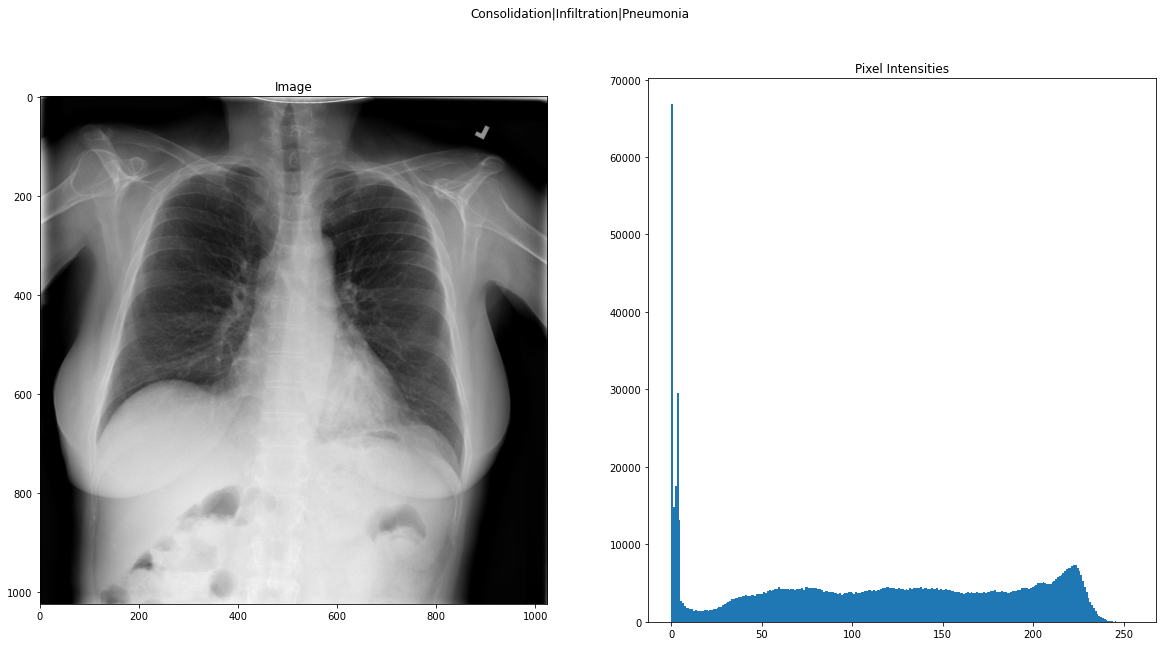

In [13]:
## An example of 'Consolidation|Infiltration|Pneumonia'
image_path = '/data/images_002/images/00001529_004.png'
image = Image.open(image_path, 'r')
pixels = np.array(image)

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Consolidation|Infiltration|Pneumonia')
fig.add_subplot(1, 2, 1)
plt.imshow(pixels, cmap='gray')
plt.title('Image')
fig.add_subplot(1, 2, 2)
plt.hist(pixels.ravel(), bins = 256)
plt.title('Pixel Intensities')

Here it seems like the intensity profile of an image with co-occurance of consolidation, infiltration, pneumonia' looks very similar to that of just pneumonia. 

Text(0.5, 1.0, 'Pixel Intensities')

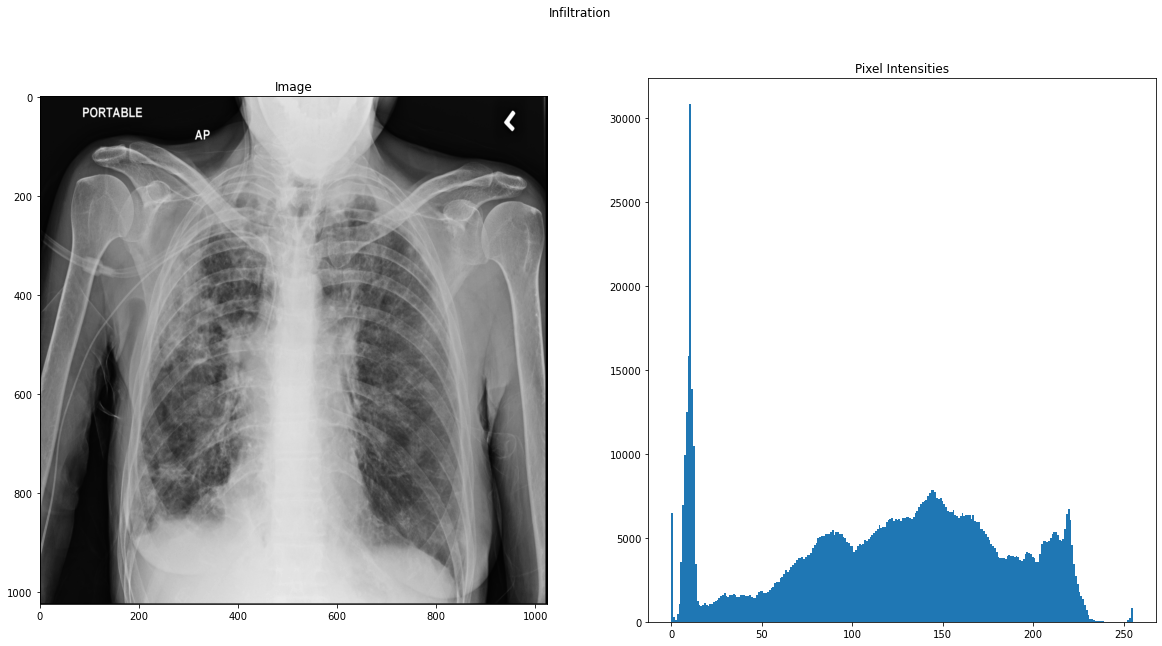

In [14]:
## An example of 'Infiltration'
image_path = '/data/images_004/images/00007816_007.png'
image = Image.open(image_path, 'r')
pixels = np.array(image)

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Infiltration')
fig.add_subplot(1, 2, 1)
plt.imshow(pixels, cmap='gray')
plt.title('Image')
fig.add_subplot(1, 2, 2)
plt.hist(pixels.ravel(), bins = 256)
plt.title('Pixel Intensities')

**Note:** Here we can see it is nearly impossible to tell the difference between infiltration and pneumonia from just plotting their respective intensity profiles. 

Text(0.5, 1.0, 'Pixel Intensities')

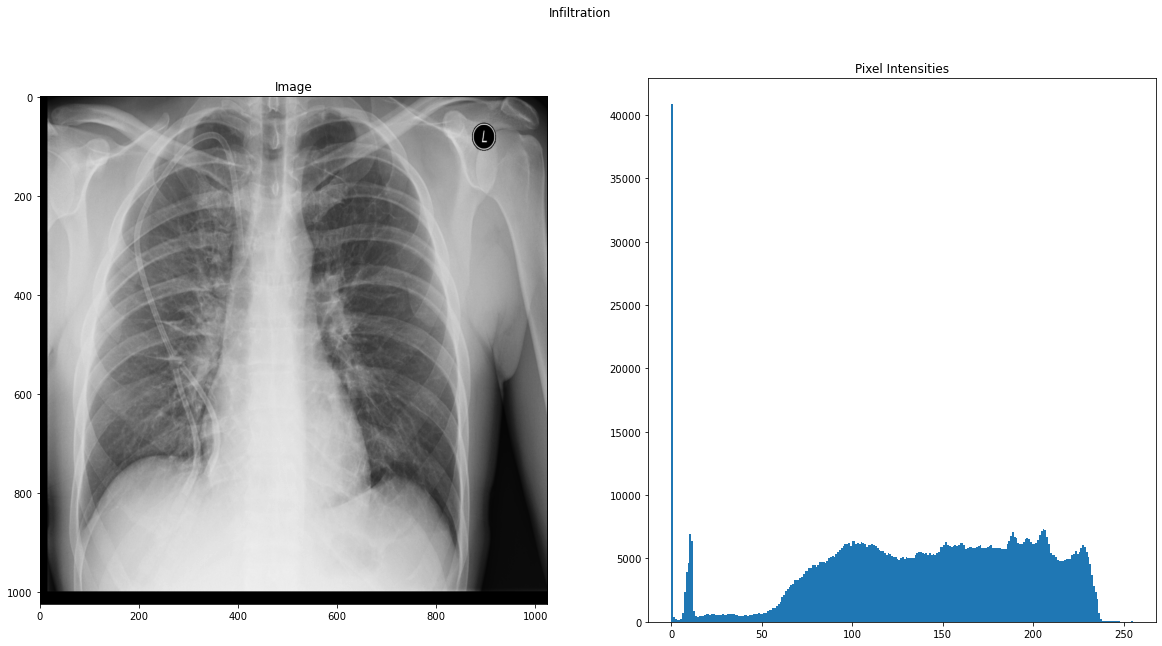

In [15]:
## Another example of 'Infiltration'
image_path = '/data/images_009/images/00020094_005.png'
image = Image.open(image_path, 'r')
pixels = np.array(image)

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Infiltration')
fig.add_subplot(1, 2, 1)
plt.imshow(pixels, cmap='gray')
plt.title('Image')
fig.add_subplot(1, 2, 2)
plt.hist(pixels.ravel(), bins = 256)
plt.title('Pixel Intensities')

In fact, there can be minor differences between intensity profiles of the same diagnosis. 

## Conclusion:

Just by looking at the intensity profiles of images with non-pneumonia, pneumonia, and pneumonia with other diseases co-occurring, it is nearly impossible to tell the differences among them. While a healthy chest X-ray does look like it has distinct features than a chest X-ray with findings, healthy chest X-ray is not the only negative standard that we are ruling against when trying to detect pneumonia. So we conclude that we need a classification algorithm that takes many more factors into account when trying to tell whether a patient has pneumonia from his or her chest X-ray